In [2]:
%%capture
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("..")
import statnlpbook.util as util
import statnlpbook.parsing as parsing
util.execute_notebook('parsing.ipynb')

<!---
Latex Macros
-->
$$
\newcommand{\Xs}{\mathcal{X}}
\newcommand{\Ys}{\mathcal{Y}}
\newcommand{\y}{\mathbf{y}}
\newcommand{\balpha}{\boldsymbol{\alpha}}
\newcommand{\bbeta}{\boldsymbol{\beta}}
\newcommand{\aligns}{\mathbf{a}}
\newcommand{\align}{a}
\newcommand{\source}{\mathbf{s}}
\newcommand{\target}{\mathbf{t}}
\newcommand{\ssource}{s}
\newcommand{\starget}{t}
\newcommand{\repr}{\mathbf{f}}
\newcommand{\repry}{\mathbf{g}}
\newcommand{\x}{\mathbf{x}}
\newcommand{\prob}{p}
\newcommand{\a}{\alpha}
\newcommand{\b}{\beta}
\newcommand{\vocab}{V}
\newcommand{\params}{\boldsymbol{\theta}}
\newcommand{\param}{\theta}
\DeclareMathOperator{\perplexity}{PP}
\DeclareMathOperator{\argmax}{argmax}
\DeclareMathOperator{\argmin}{argmin}
\newcommand{\train}{\mathcal{D}}
\newcommand{\counts}[2]{\#_{#1}(#2) }
\newcommand{\length}[1]{\text{length}(#1) }
\newcommand{\indi}{\mathbb{I}}
$$

# Parsing

##  Motivation 

Say want to automatically build a database of this form

| Company | Parent    |
|---------|-----------|
| Google  | Alphabet  |
| Bing    | Microsoft |  

Say you find positive textual mentions in this form:

> **Alphabet** is the parent company of **Google**


> **Microsoft**, based in Redmond, is the parent company of **Bing** 


Can you find a pattern? 

How about this sentence 

> **Alphabet** is the main competitor of X and the parent company of **Google** 


Wouldn't it be great if we knew that

Alphabet is the subject of the phrase *the parent company of **Google** *

Check out [enju parser](http://www.nactem.ac.uk/enju/demo.html#2)

How is this done?

## Syntax
from the Greek syntaxis (arrangement):

* **Constituency**: groups of words act as single units.
* **Grammatical Relations**: object, subject, direct object etc. 
* **Subcategorization**: restrictions on the type of phrases that go with certain words.


### Constituency

* Noun Phrase: **the company Alphabet** is **the owner of Google**
* Verb Phrase: Facebook **has recently bought** Oculus Blah
* Prepositional Phrase: The man shot the elephant **with a gun**

### Grammatical Relations

* *Subject* of buy: **Facebook** has recently bought Oculus Blah
* *Object* of buy: Facebook  has recently bought **Oculus Blah**

### Subcategorization

* Transitive Verbs: X gave to Y 
* Agreement: ...


## Context Free Grammars 

Formalise syntax by describing the hierarchical structure of sentences


A **Context Free Grammar** (CFG) is a 4-tuple \\(G=(N,\Sigma,R,S)\\) where

  * \\(N\\) is a set of _non-terminal symbols_.
  * \\(\Sigma\\) is a set of _terminal symbols_.
  * \\(R\\) is a finite set of _rules_ \\(X \rightarrow Y_1 Y_2\ldots Y_n\\) where \\(X \in N\\) and \\(Y_i \in N \cup \Sigma\\). 
  * \\(S \in N\\) is a _start symbol_. 


In [3]:
cfg = CFG.from_rules([('S',    ['NP_p','VP_p']),('S',['NP_s','VP_s']), 
                      ('NP_p', ['Matko', 'raps']),
                      ('VP_p', ['are', 'ADJ']),
                      ('NP_s', ['Matko']),
                      ('VP_s', ['raps', 'in', 'StatNLP']),
                      ('ADJ',  ['silly'])
                     ])
cfg

S,NP_p VP_p
S,NP_s VP_s
NP_p,Matko raps
VP_p,are ADJ
NP_s,Matko
VP_s,raps in StatNLP
ADJ,silly


## (Left-most) Derivation
Sequence of words \\(s_1 \ldots s_n\\) such that 

* \\(s_1 = S\\)
    * first string is the start
* \\(s_n \in \Sigma^*\\)
    * last string consists of only terminals.
* \\(s_i\\) for \\(i > 1\\)
    * replace left-most non-terminal \\(\alpha\\) in $s_{i-1}$ with right-hand of $\alpha\rightarrow \beta_1,\ldots,\beta_n$


In [4]:
generate_deriv(cfg, [cfg.s])

(['S'],
 ['NP_p', 'VP_p'],
 ['Matko', 'raps', 'VP_p'],
 ['Matko', 'raps', 'are', 'ADJ'],
 ['Matko', 'raps', 'are', 'silly'])

## Parse Trees
Represent derivations as trees

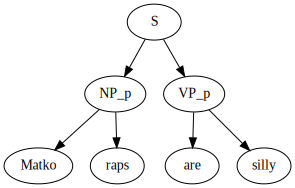

In [9]:
tree = ('S', [('NP_p',['Matko','raps']), ('VP_p',['are','silly'])])
parsing.render_tree(tree)

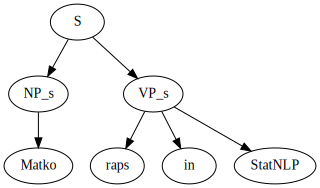

In [10]:
parsing.render_tree(generate_tree(cfg,'S'))        

## Parsing
The inverse problem: given a sentence 

> Matko raps in StatNLP

What's the derivation for it?  

There are a couple of approaches to find a legal parse tree given a sentence and grammar:

* **Top-Down**: Start with the start symbol and generate trees
    * backtrack if they do not match observed sentence
* **Bottom-Up**: Start with the sentence find rules that generate parts of it
    * backtrack if you can't reach a start symbol
* **Dynamic Programming**: Explore several trees in parallel and re-use computations

### Bottom-Up Parsing with Backtracking

Incrementally build up a tree **left-to-right**, and maintain

* a **buffer** of remaining words
* a **stack** of trees build so far

Perform three types of actions:

* **Shift**: Put word from buffer to stack (as singleton tree)
* **Reduce**: Apply rule to the top elements in the stack and replace them with result
* **Backtrack**: If no rule can be found and the buffer is non-empty, go back to last decision point

In [17]:
sentence = ['Matko', 'raps', 'are', 'silly']
transitions = bottom_up_parse(cfg, sentence)
parsing.render_transitions(transitions[0:1])

Matko raps are silly,"<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.38.0 (20140413.2041) --> <!-- Title: %3 Pages: 1 --> %3",Init


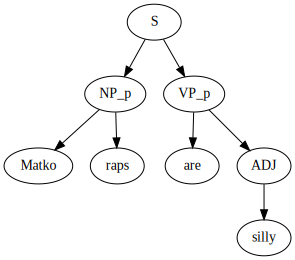

In [18]:
parsing.render_forest(transitions[-1][0].stack)

## Dynamic Programming for Parsing
A problem with the bottom-up parser is the fact that, after back-tracking, it may redo many steps it had already before (can you find examples of this behaviour in the transitions above?). This suggests to remember steps and re-use then when needed. This is the general idea behind _dynamic programming_: caching and reusing computation whenever possible. 


### Chomsky Normal Form
In the case of CFG parsing there exists a very effective dynamic program, the so-called Cocke–Younger–Kasami (CYK) algorithm. However, before we can apply this algorithm we need to _normalize_ the grammar. In particular, we need to make sure that each rule has one of the following forms:

* \\(\alpha \rightarrow \beta \gamma\\) where \\(\beta,\gamma \in N \setminus \\{ S  \\} \\). 
* \\(\alpha \rightarrow t\\) where \\(t \in \Sigma\\).

In words: each rule is either binary and expands into two non-terminal non-Start symbols, or unary and expands into a word. This form is called _Chomsky Normal Form_ (CNF). 

## Conversion to CNF
Fortunately we can convert every CFG into an equivalent CFG in CNF, in the sense that any derivation or parse of sentence in one grammar can be loss-lessly converted to a derivation in the other grammar. This can be achieved through a few simple transformations. Here the rules on the left-hand side of the transformation arrow $\Rightarrow$ will be replaced by the ones on the left-hand side:  

* $\alpha \rightarrow \beta \gamma \delta \Rightarrow \alpha \rightarrow \beta\alpha', \alpha' \rightarrow \gamma \delta$
* $\alpha \rightarrow \beta t \Rightarrow \alpha \rightarrow \beta \alpha', \alpha' \rightarrow t$ where $t \in \Sigma$
* $\alpha \rightarrow \beta, \beta \rightarrow \gamma \Rightarrow \alpha \rightarrow \gamma, \beta \rightarrow \gamma$ 

We present this conversion in Python below, but omitted the third transformation which is not relevant for the  grammar we are using here (Exercise: add this case).

In [9]:
cnf_cfg = to_cnf(cfg)
cnf_cfg

S,NP_p VP_p
S,NP_s VP_s
NP_p_0,Matko
NP_p_1,raps
NP_p,NP_p_0 NP_p_1
VP_p_2,are
VP_p,VP_p_2 ADJ
NP_s,Matko
VP_s_4,raps
VP_s,VP_s_4 VP_s_3
VP_s_3_5,in


### CYK algorithm
The CYK algorithm caches, for each span in the sentence, all possible trees that can cover the span according to the CFG. The core abstraction that enables the CYK algorithm is a *chart*: a table that stores, for each span $(i,j)$ (where $i\leq j$) of the sentence the set of possible non-terminal labels the grammar supports for this span together with a pointer to two chart cells that were used to produce the label. We provide the python class `parsing.Chart` that implements such a chart together with a way to visualise the triangular structure of the chart.

In [10]:
chart = parsing.Chart(sentence)
chart.append_label(0,0,'NP_s')
chart.append_label(0,0,'NP_p_0')
chart.append_label(1,1,'VP_s_6')
chart.append_label(1,1,'NP_p_1')
chart.append_label(0,1,'NP_p_2', [(0,0,'NP_p_0'),(1,1,'NP_p_1')]) 
chart.mark(0, 1, 'NP_p_2')
chart.mark_target(0,1)
chart

,0: Matko,1: raps,2: are,3: silly
0: Matko,"NP_s, NP_p_0",NP_p_2,,
1: raps,,"VP_s_6, NP_p_1",,
2: are,,,,
3: silly,,,,


The CYK algorithm operates this chart as follows:

* **Input**: sentence $s=s_1 \ldots s_n$, CFG $G=(N, \Sigma, R, S)$ in Chomsky Normal Form.
* **Initialisation**:
  * $C(i,j)=\emptyset$ for all $i < j$, $i,j \in \{1,\ldots, n\}$
  * $P(i,j,l)=\emptyset$ for all $i < j$, $i,j \in \{1,\ldots, n\}$ and $l \in N$
  * **for** $i = 1 \ldots n$ 
    * **for** every terminal rule $\alpha \rightarrow s_i \in R$
      * $C(i,i) \leftarrow \{ \alpha \} $
* **for** $w \in 1, \ldots, n$ 
  * **for** $b \in 1, \ldots, n - 1$
    * $e \leftarrow b + w$
    * **for** $m \in b, \ldots, e$
      * **for** $\beta \in C(b,m)$ and $\gamma \in C(m + 1, e)$ **if** $\alpha \rightarrow \beta \gamma \in R$
        * $C(b,e) \leftarrow C(b,e) \cup \{ \alpha \} $
        * $P(i,j,l) \leftarrow P(i,j,l) \cup \{((b,m,\beta),(m+1,e,\gamma)) \}$  
        
We can implement this algorithm in Python as follows. Notice that we keep track of all steps of the algorithm for later introspection. In real applications this is not needed.

In [11]:
trace = cyk(cnf_cfg, sentence)
trace[-1]

,0: Matko,1: raps,2: are,3: silly
0: Matko,"NP_p_0, NP_s",NP_p,,S
1: raps,,"NP_p_1, VP_s_4",,
2: are,,,VP_p_2,VP_p
3: silly,,,,ADJ


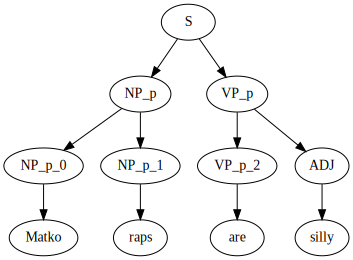

In [12]:
parse_result = trace[-1].derive_trees()[0]
parsing.render_tree(parse_result)

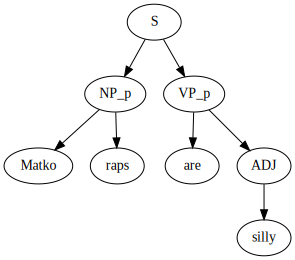

In [13]:
parsing.render_tree(parsing.filter_non_terminals(parse_result, cfg.n))

In [14]:
util.Carousel(trace)

,0: Matko,1: raps,2: are,3: silly
0: Matko,,,,
1: raps,,,,
2: are,,,,
3: silly,,,,
,0: Matko,1: raps,2: are,3: silly
0: Matko,,,,
1: raps,,,,
2: are,,,,
3: silly,,,,
,0: Matko,1: raps,2: are,3: silly


## Ambiguity 
For real world grammars many phrases have several legal parse trees. Which one is the correct one depends on the intent of the speaker. That said, in many cases it is quite obvious that one parse tree should be more likely, or have a higher _probability_. This suggest a probabilistic treatment of grammars and parsing. Before we introduce probabilistic CFGs, let us inspect a typical case of syntactic natural language ambiguity.

Consider the following grammar and sentence.

In [15]:
amb_cfg = CFG.from_rules([
        ('S',    ['Subj','VP']),
        ('Subj', ['He']),
        ('Verb', ['shot']),
        ('VP',   ['Verb', 'Obj']),        ('VP', ['Verb', 'Obj', 'PP']),
        ('PP',   ['in','his','pyjamas']),
        ('Obj',  ['the','elephant']),     ('Obj', ['the','elephant','PP'])
    ])
amb_cnf_cfg = to_cnf(amb_cfg)
amb_sentence = ["He", "shot", "the", "elephant", "in", "his", "pyjamas"]

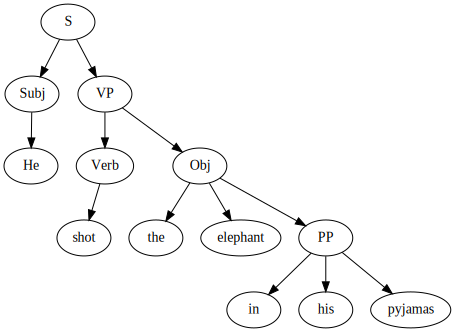

In [16]:
amb_trace = cyk(amb_cnf_cfg, amb_sentence)
amb_parse_results = amb_trace[-1].derive_trees()
parsing.render_tree(parsing.filter_non_terminals(amb_parse_results[0],amb_cfg.n)) # try results[1]

The example is an instance of _prepositional phrase attachment ambiguity_: the "in his pyjamas" phrase could both be part of the verb phrase, meaning that the shooting happened in pyjamas, or part of the noun phrase "the elephant", meaning that the elephant was in pyjamas. Both readings make syntactic sense, so there is nothing wrong with the grammar. However, we would like the machine to return the preferred reading when such sentence is parsed. For this we need to find a way to assign different readings different probabilities. <span class="summary">Can we assign the better parse a higher _probability_?</span> 

## Probabilistic Context Free Grammars
[Probabilistic Context Free Grammars](http://www.cs.columbia.edu/~mcollins/courses/nlp2011/notes/pcfgs.pdf) (PFCGs) are Context Free Grammars in which rules have probabilities. More formally, a PCFG consists of 

* A Context Free Grammar \\(G(N,\Sigma,R,S)\\).
* A parameter \\(\param(\alpha \rightarrow \beta)\\) for each rule  \\(\alpha \rightarrow \beta \in R\\). For each possible left hand side \\(\alpha \in N\\) we require \\(\sum_\beta \param(\alpha \rightarrow \beta) = 1\\).

A PCFG defines a probability distribution over parse trees as follows. Given a parse tree \\(\mathbf{t}\\) that contains the rules \\(\alpha_1 \rightarrow \beta_1, \ldots, \alpha_n \rightarrow \beta_n\\), the probability of this tree under the PCFG is:
$$
  \newcommand{parse}{\mathbf{t}}
  p_{\param}(\parse) = \prod_i^n \param(\alpha_i \rightarrow \beta_i) 
$$

Notice that we can develop and operate parsers with the structured prediction recipe. We have model \\(p\\), some parameters \\(\params\\) that need to be estimated on a training set, and the prediction/search problem of finding the most likely parse tree given a sentence. The next sections will cover these aspects.

Before we show examples, let us define a Python data structure for PCFGs.    

In [17]:
pcfg = PCFG.from_rules([
        ('S',    1.0, ['Subj','VP']),
        ('Subj', 1.0, ['He']),
        ('Verb', 1.0, ['shot']),
        ('VP',   0.3, ['Verb', 'Obj']),        ('VP',  0.7, ['Verb', 'Obj', 'PP']),
        ('PP',   1.0, ['in','his','pyjamas']),
        ('Obj',  0.5, ['the','elephant']),     ('Obj', 0.5, ['the','elephant','PP'])
    ])
pcfg

S,1.0,Subj VP
Subj,1.0,He
Verb,1.0,shot
VP,0.3,Verb Obj
VP,0.7,Verb Obj PP
PP,1.0,in his pyjamas
Obj,0.5,the elephant
Obj,0.5,the elephant PP


## Prediction / Parsing

Let us first focus on the prediction task: given a sentence, find the highest scoring parse tree consistent with this sentence. A tree is consistent with a sentence if its leaf terminal nodes are equal to the sentence. In a way, we have already solved a variant of this problem. We can consider a CFG as a deterministic distribution over trees, and finding _a_ highest scoring parse is equivalent to finding any legal tree&mdash;our bottom-up and dynamic program based algorithms hence performed a structured prediction.

More formally, we can understand the PCFG distribution $\prob_{\params}(\parse)$ as joint distribution $\prob_{\params}(\x,\y)$ over a non-terminal upper part of the tree $\y$ (which includes for each of its own leaf nodes the number of terminal children it should have) and a terminal lower part $\x$ corresponding to the input sentence. Both $\x$ and $\y$ form the parse tree $\parse$. Notice that for a given sentence $\x$ a *legal* upper tree $\y$ needs to have a total number of children identical to the length of $\x$. If we assume that the PCFG rules involving non-terminal nodes are in normal form ($\alpha \rightarrow t$ with $t \in \Sigma$) a legal $\y$ needs to have as many children as there are tokens in $\x$. Let us define the set of legal (non-terminal) parse trees for a given sentence $\x$ and grammar $G$ as $\Ys(\x,G)$.

With the above definitions we can define the parsing or prediction problems as follows. 

$$
\argmax_{\y \in \Ys(\x,G)} \prob_\params(\x | \y) = \argmax_{\y \in \Ys(\x,G)} \prob_\params(\x , \y)
$$

where the equality follows from $\prob_\params(\x | \y) \propto \prob_\params(\x , \y)$.

## CYK for PCFGs

As it turns out, we can use a variant of the CYK algorithm to solve the prediction problem above if we again assume (without loss of generality) that the grammar is CNF. As first step we hence need to convert the PCFG into a normalised PCFG: 

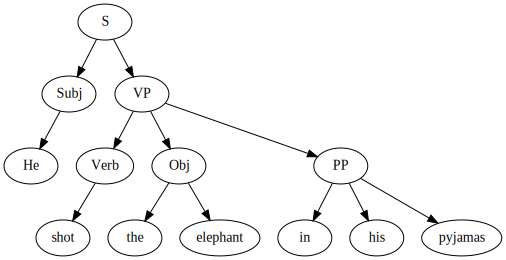

In [18]:
pcyk_trace = pcyk(cnf_pcfg, amb_sentence)
parsing.render_tree(parsing.filter_non_terminals(pcyk_trace[-1].derive_trees()[0],pcfg.cfg.n))

In [19]:
util.Carousel(pcyk_trace)

,0: He,1: shot,2: the,3: elephant,4: in,5: his,6: pyjamas
0: He,,,,,,,
1: shot,,,,,,,
2: the,,,,,,,
3: elephant,,,,,,,
4: in,,,,,,,
5: his,,,,,,,
6: pyjamas,,,,,,,
,0: He,1: shot,2: the,3: elephant,4: in,5: his,6: pyjamas
0: He,,,,,,,
1: shot,,,,,,,


## Learning

Learning in the context of PCFGs usually amounts to asking two questions:

1. What should the rules in the grammar be?
2. What should the probabilities associated with these rules be?

Usually both questions are answered with the use of a training corpus of parse trees $\train=(\parse_1, \ldots, \parse_n)$. Such corpora exists for various domains and languages. Most famously, the [Penn Treebank Project](https://www.cis.upenn.edu/~treebank/) consists of a large number of parse trees for sentences in the 1989 Wall Street Journal (among other sources). The exist similar (but usually smaller) corpora for other languages (e.g. [Chinese](https://catalog.ldc.upenn.edu/LDC2013T21)) and other domains (e.g. [Biomedical Papers](www.nactem.ac.uk/aNT/genia.html)). The corpora are usually created by linguistic experts that produce parse trees for a list of sentences given to them. This is generally an expensive process as it need experts, and traditionally formed some bottleneck in parsing research. 

With a corpus $\train$ we can answer the question of which rules to use by assessing what rules (sub-trees of parent $\alpha$ and list of children $\beta_1 \ldots \beta_m$) exists in the corpus. One could simply use all rules that appear in the data, or maybe filter using some threshold (TODO references?). 

To learn the parameters $\params$ of the model we can again use the maximum-likelihood criterium:

$$
\params^* = \argmax_\params \sum_{\parse \in \train} \log \prob_\params(\parse)
$$

As before, maximising this objective simply amounts to counting. This time we divide the number of times a rule has been observed in the data by the number of times the non-terminal has been seen in total.

$$
  \param(\alpha \rightarrow \beta) = \frac{\counts{\train}{\alpha \rightarrow \beta}}{\counts{\train}{\alpha}}
$$

We omit an implementation of this training regime as we have seen similar implementations in previous chapters (check for example the [language model](language-models.ipynb) chapter).

## Advanced: Head Driven PCFG

* Probabilities depend on words
* Give Example (shot & gun) 
* Understand notion of syntactic head
* Show simplified head driven distribution
* Talk about syntactic parsing and show CoreNLP


## Background Material

* [Mike Collins' PCFG lecture](http://www.cs.columbia.edu/~mcollins/courses/nlp2011/notes/pcfgs.pdf)
* Jurafsky & Martin